<a href="https://colab.research.google.com/github/Rosie-Brigham/colab-gists/blob/main/model_2s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transfer learning with segmentation using deeplab model

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision import models
from torch.utils.data import Dataset
from torchvision import transforms
import torch


In [ ]:
# Clone down training data

!git clone https://github.com/monumentalconservation/training_data.git

Cloning into 'training_data'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 483 (delta 28), reused 71 (delta 24), pack-reused 406
Receiving objects: 100% (483/483), 60.54 MiB | 31.14 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
kDatasetSize = 200
kBatchSize = 5

In [ ]:
# input data is 3D (not 4D)

In [ ]:
sheets2 = pd.DataFrame(columns=['Image_name','Label_name'])
msk_names = os.listdir('training_data/masks')
img_names = os.listdir('training_data/images')
sheets2['Image_name'] = [i.replace('.png','.jpeg') for i in msk_names]
sheets2['Label_name'] = msk_names

In [ ]:
dir_ = 'training_data'
subfolder = 'images'

for img_name in sheets2['Image_name']:
    img = Image.open(f'{dir_}/{subfolder}/{img_name}')
    if img.mode == 'RGBA':
        print(img_name, img.mode)

In [ ]:
dir_ = 'training_data'
subfolder = 'masks'

for img_name in sheets2['Label_name']:
    img = Image.open(f'{dir_}/{subfolder}/{img_name}')
    if img.mode == 'RGBA':
        print(img_name, img.mode)


The following cell constructs a Dataset class to help the model load data in the training phase.

In [ ]:
# Added in because of some pesky RGBA images
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL (http://stackoverflow.com/a/1963146)
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format
        # (http://stackoverflow.com/a/8720632  and  http://stackoverflow.com/a/9459208)
        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

class Segdata(Dataset): # A customized Dataset class inherited from PyTorch. Refer to https://pytorch.org/docs/stable/data.html#map-style-datasets

    def __init__(self,image_size, csv_file, dic,input_label_foler):
        self.data = csv_file
        self.dic = dic
        self.input_label_foler = input_label_foler
        self.transform_image = transforms.Compose([transforms.Resize(image_size), # Difine a pipeline to process all the input images
                                                  transforms.ToTensor(),
                                                  transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
        # normalize(tensor, mean, std, inplace)
        # RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0
        
        # find which image / label has a 4th dimension (maybe Alpha Transparency Layer.)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Load the image and transfer it to tensor
        img_name = self.data.loc[idx, 'Image_name']
        image = Image.open(r'{0}/{1}/{2}'.format(self.dic,self.input_label_foler[0],img_name))
        # removing alpha channel :fingers_crossed:
        
        image = remove_transparency(image)
        image = self.transform_image(image)

        # Load the label and transfer it to tensor
        label_name = self.data.loc[idx, 'Label_name']
        label = Image.open(r'{0}/{1}/{2}'.format(self.dic,self.input_label_foler[1],label_name)).resize(image_size).convert('1') # binarize the label image
        label = remove_transparency(label)
        label = torch.tensor(np.array(label).astype(np.uint8)).squeeze() 

        return {
                'image': image,
                'labels': label
                }

In [ ]:
image_size = (400,400) # All the input images and labels have to be resized into this solution

example_dataset_train = Segdata(image_size,
                                sheets2[:kDatasetSize], # training set
                                'training_data', # the path of parent directory
                                ['images','masks'] # Subfolders containning images and masks
                                )

transform_test = transforms.Compose([transforms.Resize(image_size), # Difine a pipeline to process all the input images
                                                     transforms.ToTensor(),
                                                     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

The following cell defines the structure of the model. Here we use Deeplabv3 implemented by TorchVision. We import the pre-trained backbone model and a new classifier, and combine them into a new model. Then we freeze the parameters of the backbone to not train them in the training phase.

In [ ]:
device = torch.device("cuda:0") #Using GPU to train the model
num_c = 2 # Number of classes, 0:Background 1:Crack

class DLAB(torch.nn.Module): # Define a model structure that includes the pre-trained backbone and a initialized classifier
    def __init__(self,model1_1,model1_2):
        super().__init__()
        self.model1_1 = model1_1
        self.model1_2 = model1_2
    def forward(self,x):
        x = self.model1_1(x)['out']
        x = self.model1_2(x)
        x = torch.functional.F.interpolate(x, size=image_size, mode='bilinear', align_corners=False) # Interpolate the final result to the resolution of the input image (300x300)
        return x
        
dlab1 = models.segmentation.deeplabv3_resnet101(pretrained=1).to(device)

dlab2 = models.segmentation.deeplabv3_resnet101(pretrained=0,num_classes=num_c).to(device)

model = DLAB(dlab1.backbone,dlab2.classifier)

for name, param in model.named_parameters(): # freeze the parameters of backbone
    if name.startswith('backbone'):
        param.requires_grad = False 

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


The image segmentation is the process of partitioning a digital image into multiple segments. The training process is training the model to assign a correct label to each pixel in an image based on the given groundtruth label. Besides, a loss function is also required to measure the differences between the preditions and true labels. This loss function may vary depending on different tasks or model structures. The following cell demonstrates the training process of the model (this may take some time).

In [ ]:
# LOAD PREVIOUS MODEL to continue training (comment if you want to train model from scratch)
# mount drive to save model to
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/My Drive/PhD/models/model_two/water-400-trained-epochs.pt" 
# model.load_state_dict(torch.load(path))


In [ ]:
# class_sample_count = np.unique(target, return_counts=True)[1]
# weight = 1. / class_sample_count
# samples_weight = weight[target]
# samples_weight = torch.from_numpy(samples_weight)
# weight = samples_weight

weight = 1/torch.tensor([0.8,0.2]).to(device)

print(weight)

tensor([1.2500, 5.0000], device='cuda:0')


finished 1th training
finished 2th training
finished 3th training
finished 4th training
finished 5th training
finished 6th training
finished 7th training
finished 8th training
finished 9th training
finished 10th training
finished 11th training
finished 12th training
finished 13th training
finished 14th training
finished 15th training
finished 16th training
finished 17th training
finished 18th training
finished 19th training
finished 20th training
finished 21th training
finished 22th training
finished 23th training
finished 24th training
finished 25th training
finished 26th training
finished 27th training
finished 28th training
finished 29th training
finished 30th training
finished 31th training
finished 32th training
finished 33th training
finished 34th training
finished 35th training
finished 36th training
finished 37th training
finished 38th training
finished 39th training
finished 40th training
finished 41th training
finished 42th training
finished 43th training
finished 44th traini

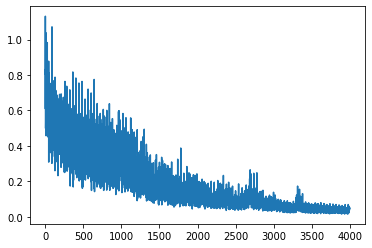

In [ ]:
n_epoch = 100 # We train the model for n times

dataloader_train = torch.utils.data.DataLoader(example_dataset_train, 
                                               batch_size=kBatchSize, # The batch size is 5. This can be customized depending on the available RAM of GPU
                                               shuffle=False, 
                                               num_workers=0,
                                               drop_last=True)

# labelWeights
# 1 - wet
# 0 - dry - there's 80% dry pixels
criterion = torch.nn.CrossEntropyLoss(weight = 1/torch.tensor([0.8,0.2]).to(device)) # This line defines the loss function. 
                                                                                                              # Also, we set the weight for each class based on their frequency.
                                                                                                              # Here we set them as the reciprocal of their rough weight

plist = [
         {'params': model.parameters(),'lr':1e-2} # Here is the learning rate. It can be tuned based on the loss plot
         ]

optimizer = torch.optim.Adam(params=plist) # This is the optimizer that helps to update the parameters within the model during training process

# First iteration
loss_list = [] # This is used to record loss of each iteration to check the convergence of the model after finishing training

# The following codes are a pretty standard way to train a PyTorch model
for epoch in range(n_epoch):

    model.train()

    for i, sample in enumerate(dataloader_train):

        input_ = sample['image'].to(device)
        target = sample['labels'].to(device)
        res = model(input_)
        loss = criterion(res,target.long()) # Calculate loss
        loss_list.append(loss.item()) 
        loss.backward() # Backpropagate to each parameters
        optimizer.step() # Update the parameters based on the derivative of loss with respect to the parameters
        optimizer.zero_grad()

        # if epoch+1 is multiple of 50, save the model and checkpoint
        # if (epoch+1) % 50 == 0:
        #   epochs = str(epoch + 1)
        #   path = F"/content/drive/My Drive/PhD/models/{epochs}-epochs.pt" 
        #   torch.save(model.cpu().state_dict(), path) # saving model
        #   model.cuda() # moving model to GPU for further training


    print('finished {0}th training'.format(epoch+1))
_ = model.eval()

plt.plot(loss_list)

We can plot the loss to see whether it is decreasing. If it is not, we can test another learning rate.

Finally, we load an image as a test image to visually see the model's performance. It can be seen that it partitions the image into meanningful distinctive segments

In [ ]:
# Now we play with the model
model.eval()

DLAB(
  (model1_1): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

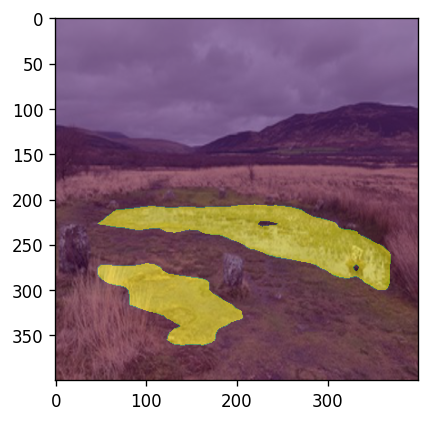

In [ ]:
example_test = Image.open(r'training_data/images/13.jpeg')

test_res = model(transform_test(example_test).unsqueeze(0).to(device))

plt.figure(dpi = 120) # We overlay the predicted results on the original image

plt.imshow(example_test.resize(image_size),alpha =1)

plt.imshow(torch.argmax(test_res.squeeze(),axis = 0).detach().cpu().numpy(),alpha = 0.5)

Then we show the groundtruth label for that image. We can see that the model's prediction is overlapped with the groundtruth label.

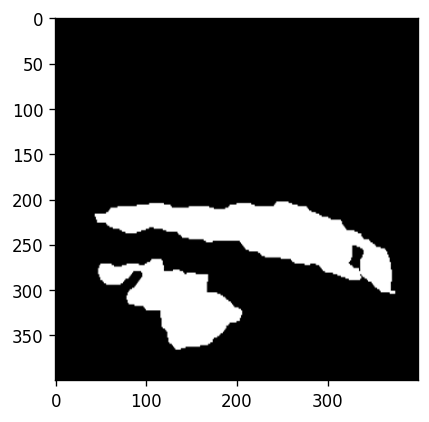

In [ ]:
example_test_label = Image.open(r'training_data/masks/13.png')

plt.figure(dpi = 120)

plt.imshow(example_test_label.resize(image_size),alpha =1)

In [ ]:
from sklearn.metrics import confusion_matrix

gt = np.array(example_test_label.resize(image_size).convert('1')).astype(np.uint8).reshape(-1,1)
pred = torch.argmax(test_res.squeeze(),axis = 0).detach().cpu().numpy().reshape(-1,1)



In [ ]:
new_ground_truth = np.array(example_test_label.resize(image_size).convert('1')).astype(np.uint8).reshape(-1,1)

print(torch.argmax(test_res.squeeze(),axis = 0).detach().cpu().numpy().reshape(-1,1))

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
print(pred.shape)

(160000, 1)


In [ ]:
pd.DataFrame(confusion_matrix(gt,pred),columns = ['Background','Water'],index = ['Background','Water'])

,Background,Water
Background,137646,1019
Water,2532,18803


The following cell shows the confusion matrix of the prediction, with figures in each position representing the number of pixels. As can be shown by the confusion matrix, the recall of the prediction is $\frac{1413}{1413+273} = 84\%$; while the precision is only $\frac{1413}{1413+1983} = 42\%$; the Intersection over Union (IoU) is $\frac{1413}{1413+1983+273} = 38.6\%$. This means that, 84\% of crack pixels were correctly predicted by the model, but among all the predictions made by the model, only 42\% were correctly predicted. It indicates that the model tends to predict more cracks over background (this may be caused by the weight in the loss function, or because of the subsampling process). All in all, this causes an overestimation of the cracks on this image.

In [ ]:
# Saving model to drive
from google.colab import drive
drive.mount('/content/drive')
model_save_name = 'water-100-trained-epochs.pt'
path = F"/content/drive/My Drive/PhD/models/model_two/{model_save_name}" 
# %ls drive/My
torch.save(model.state_dict(), path)

Mounted at /content/drive
